# Aplicación de algoritmo RollingBall

En este script se pretende replicar la experiencia con el algoritmo rollingball del paquete [baseline] de R.

Inicialmente se deben tener instalados los paquetes necesarios para el procesamiento de las imágenes.

Este paso puede **omitirse** si ya se encuentra instalado.

In [ ]:
install.packages("ggplot2")
install.packages("imager")
install.packages("mixtools")
install.packages("baseline")

Incorporamos las dependencias necesarias

In [1]:
library(mixtools)
library(baseline)
library(ggplot2)
library(imager)

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



Attaching package: ‘baseline’


The following object is masked from ‘package:stats’:

    getCall


Warning message:
“S3 methods ‘[.fun_list’, ‘[.grouped_df’, ‘all.equal.tbl_df’, ‘anti_join.data.frame’, ‘anti_join.tbl_df’, ‘arrange.data.frame’, ‘arrange.default’, ‘arrange.grouped_df’, ‘arrange.tbl_df’, ‘arrange_.data.frame’, ‘arrange_.tbl_df’, ‘as.data.frame.grouped_df’, ‘as.data.frame.rowwise_df’, ‘as.data.frame.tbl_cube’, ‘as.table.tbl_cube’, ‘as.tbl.data.frame’, ‘as.tbl.tbl’, ‘as.tbl_cube.array’, ‘as.tbl_cube.data.frame’, ‘as.tbl_cube.matrix’, ‘as.tbl_cube.table’, ‘as_tibble.grouped_df’, ‘as_tibble.tbl_cube’, ‘auto_copy.tbl_cube’, ‘auto_copy.tbl_df’, ‘cbind.grouped_df’, ‘collapse.data.frame’, ‘collect.data.frame’, ‘common_by.NULL’, ‘common_by.character’, ‘common_by.default’, ‘common_by.list’, ‘compute.data.frame’, ‘copy_to.

El primer paso consiste en cargar la imagen en una variable. La representación de la imagen está en el espacio de color RGB.

In [2]:
#Load and plot the RGB file
#data.file <- '/mnt/usb-WD_Elements_25A2_575852314531383859503438-0:0-part1/CHB/PASANTIA/imagenes_forestal/data/DJI_0805.jpg'
data.file <- '../imagenes_forestal/data/DJI_0805.jpg'
im <- load.image(data.file)

Una vez que la imagen se encuentra cargada en la variable, es posible imprimir el gráfico con la función <code>plot</code>

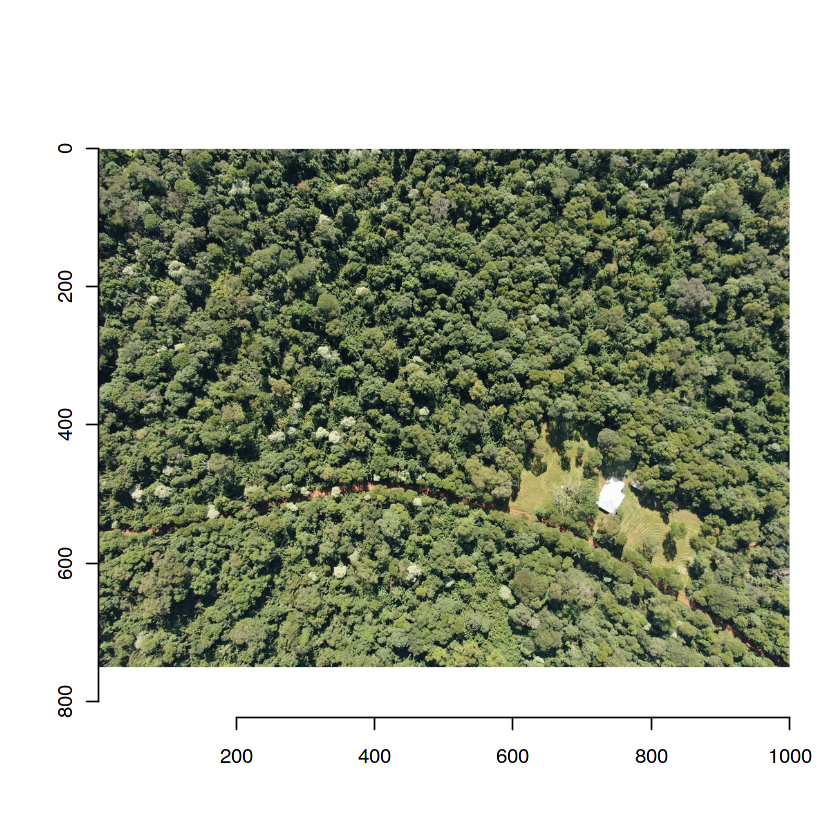

In [3]:
plot(im)

La imagen con la que se trabaja fue obtenida por medio de un dron que sobrevolaba la [reserva biósfera Yaboty](https://sib.gob.ar/area/MISIONES*YB*YABOTY), a una altitud aproximada de 600 metros. La resolución de la imagen original es de 12 Mpixels (4000 x 3000), pero fue reducida a una resolución de 1000 x 750 pixels para aliviar la carga de procesamiento.

Teniendo en cuenta los datos del vuelo, de la [cámara](https://www.dji.com/phantom-4/info) y del terreno, podemos hallar que la resolución espacial de la fotografía aérea es de 0,5 metro por pixel, aproximadamente (esto teniendo en cuenta que la imagen original fue reducida en su resolución original de 4000 x 3000 pixeles a 1000 x 750 pixeles)


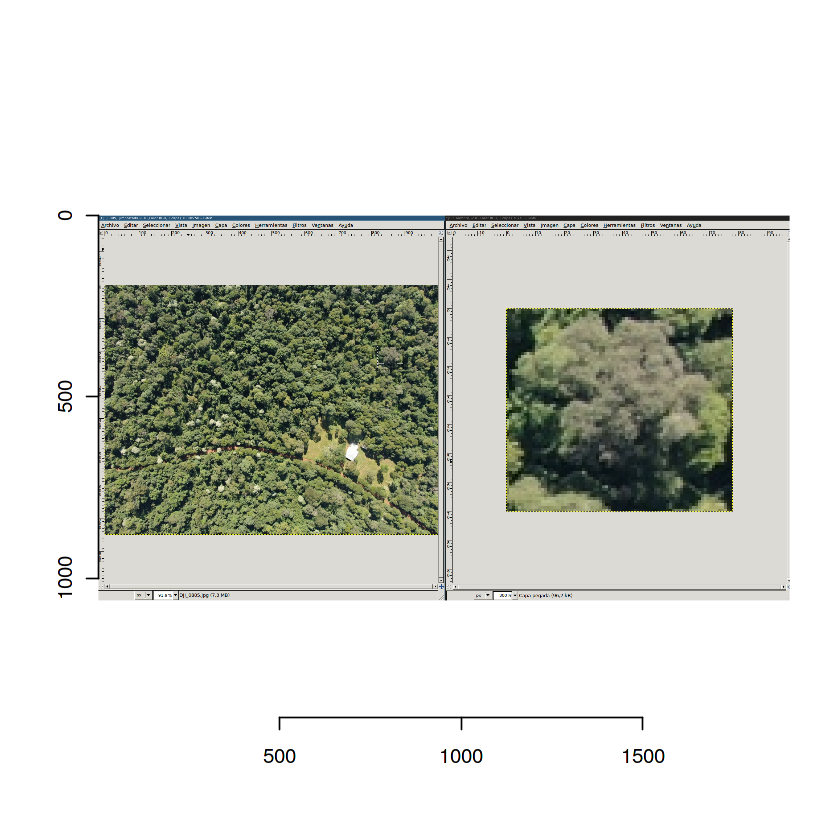

In [4]:
data.file <- '../Captura.png'
recorte <- load.image(data.file)
plot(recorte)

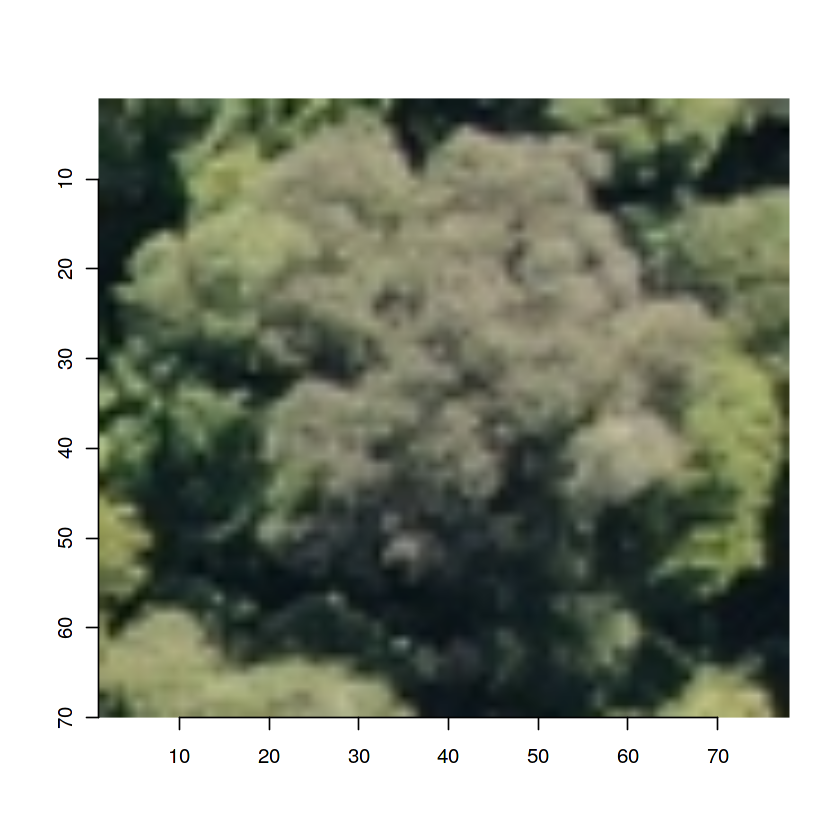

In [5]:
data.file <- '../copa_referencia.png'
recorte <- load.image(data.file)
plot(recorte)

Una observación en la imagen del recorte de la copa permite estimar el tamaño que abarca la copa en 80 píxeles. Este dato será usado en los parámetros de los filtro implementados.

Para procesar la imagen, debe ser convertida al espacio de color [HSL](https://es.wikipedia.org/wiki/Modelo_de_color_HSL), del cual se tomará la componente **L** de luminosidad.

In [6]:
#GPerforms the conversion of the image from RGB to HSL colorspace
im_hsl <- RGBtoHSL(im)

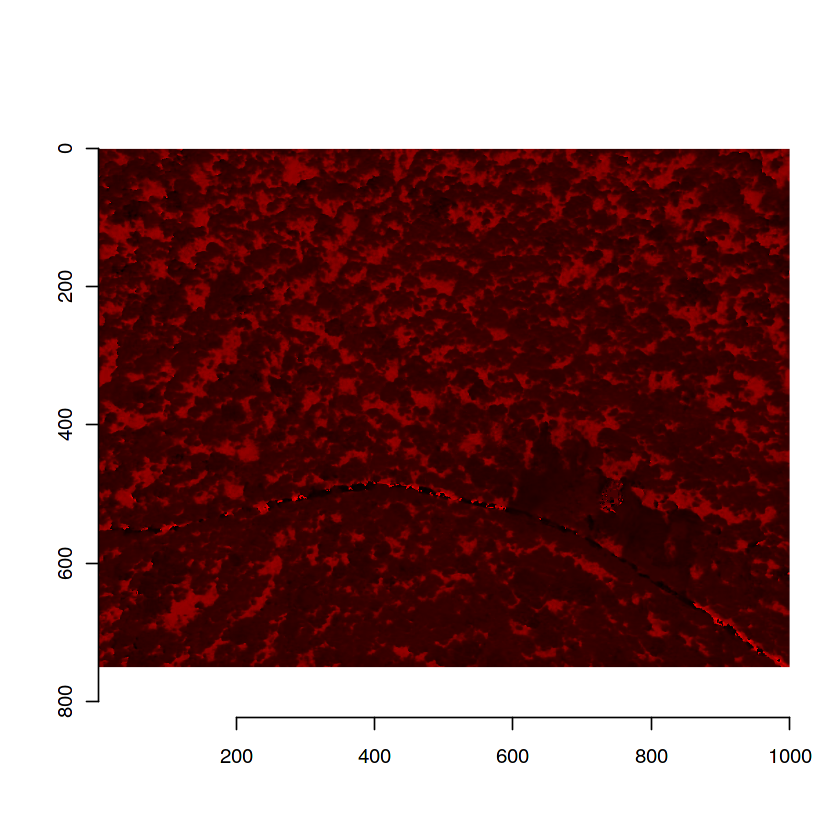

In [7]:
plot(im_hsl)

El aspecto de la imagen visualizada en su componente L del espacio HSL es de escala de grises...

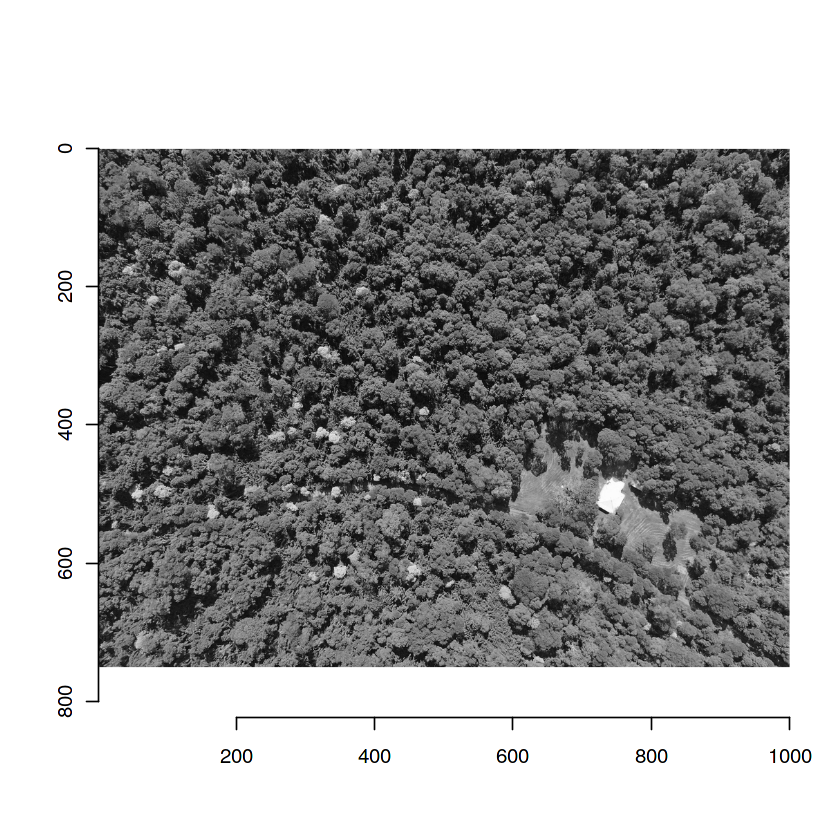

In [8]:
#prints the image L channel from the HSL colorspace. index 3 is L
plot(channel(im_hsl, 3))

Se extrae la componente L de la imagen HSL y se la almacena en una variable

In [9]:
#Extracts the L component from HSL colorspace image
im_L <- im_hsl[,,3]

# Estimación de parámetros de distribución bimodal

La función <code>normalmixEM()</code> devuelve una estimación de parámetros de la distribución de los datos de la componente L de la imagen, considerándola como una distribución normal bimodal...

In [10]:
#Estimation of bimodal distribution parameters
param <- normalmixEM(as.vector(im_L))

number of iterations= 120 


Desplegamos un histograma de los datos del canal L

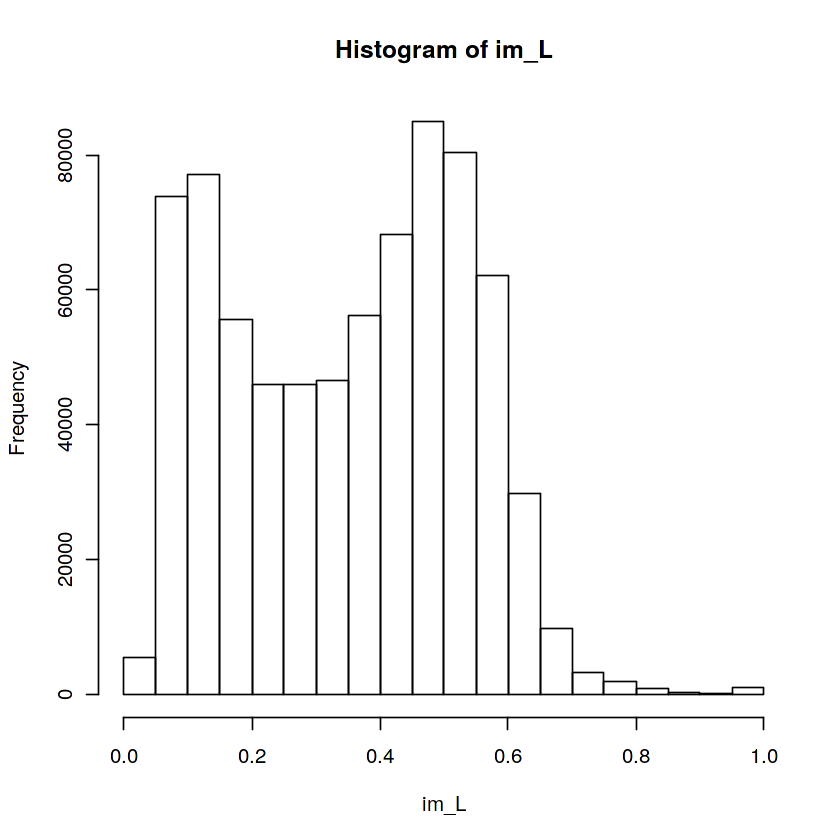

In [11]:
hist(im_L)

# Algoritmo Rolling ball

Se aplica la función <code>baseline()</code> con el método <code>rollingBall</code> y se grafica el resultado. Los parámetros <code> wm</code> y <code> ws</code> corresponden al ancho de ventana local de minimización y maximización y de suavizado respectivamente.

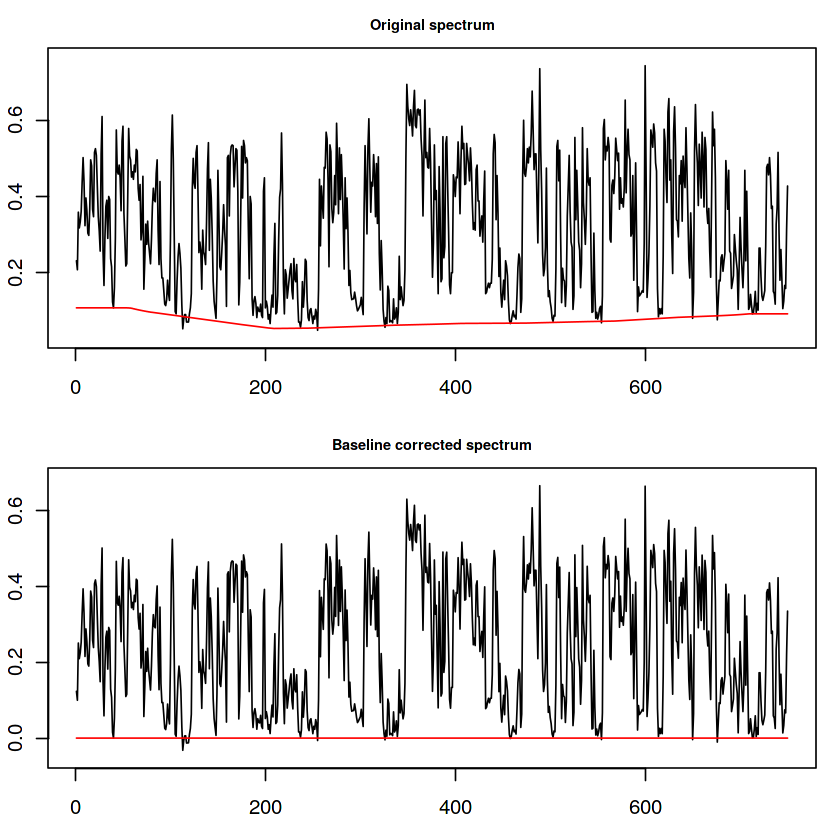

In [12]:
#Rolling ball algorithm

bc.rollingBall <- baseline(im_L, wm=80, ws=80, method='rollingBall')
## Not run: 
plot(bc.rollingBall)

Para visualizar el efecto del filtro aplicado mediante el algoritmo RollingBall convertimos los datos corregidos al formato cimg mediante la función <code>as.cimg()</code> y graficamos.

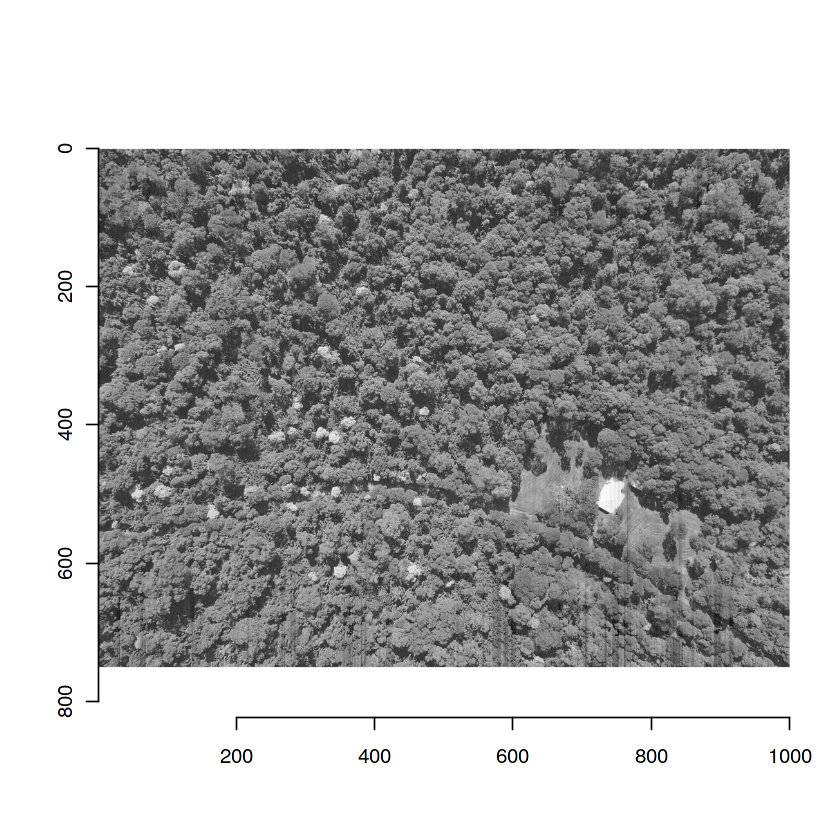

In [13]:
corregido <- as.cimg(bc.rollingBall@corrected)
plot(corregido)

# Operaciones matemáticas morfológicas

Se utilizan los operadores matemáticos morfológicos de transformaciones top hat y bottom hat, para mejorarse el contraste, basándose en un elemento estructural.

**Top hat**: es la imagen original en grises menos el resultado de la apertura (*erosión* secundada por *dilación*)

**Bottom hat**: es la imagen resultante de la cerradura (*dilación* secundada por *erosión*) menos la image original en grises
Combinando ambos se obtiene el mejoramiento del contraste sumando a la imagen original el resultado de la transformación top hat y restando el resultado de la transformación bottom hat: *If=I+Ith-Ibh*

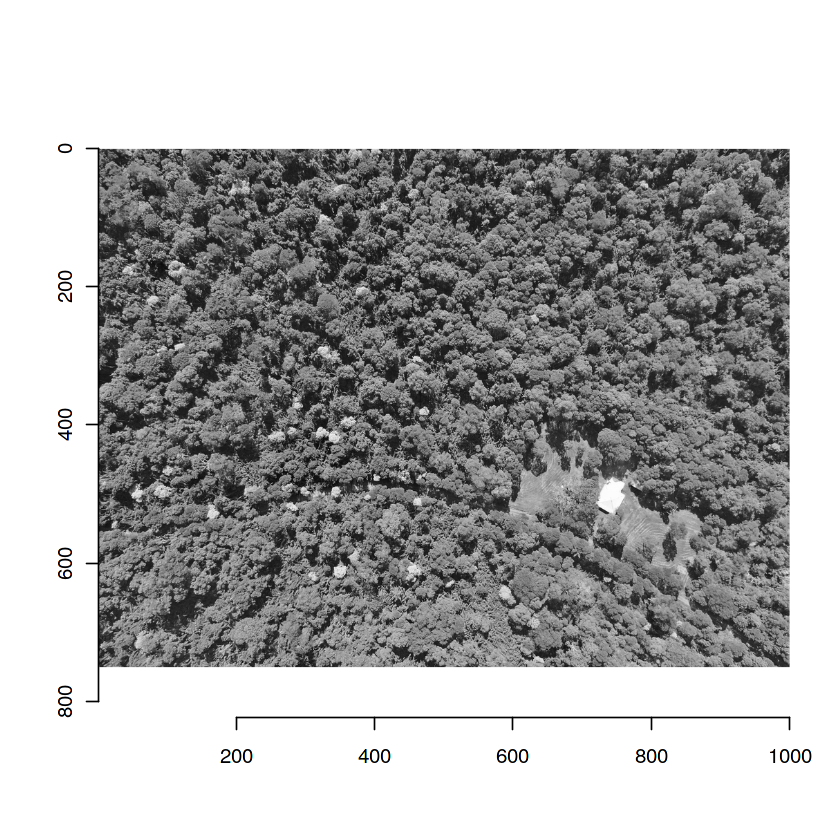

In [14]:
#Top hat y bottom hat
mask <- imfill(78,78,val=1)
top_hat <- as.cimg(im_L) - mopening(as.cimg(im_L),mask)
bottom_hat <-  mclosing(as.cimg(im_L),mask) - as.cimg(im_L)
im_filt <- as.cimg(im_L) + top_hat - bottom_hat
plot(im_filt)

# Primer identificación de objetos oscuros

Se lleva a cabo una primera identificación de objetos oscuros, definiéndolos como los que tienen un valor por debajo de la media en la distribución de grises en brechas, y a éstos se los iguala a cero.

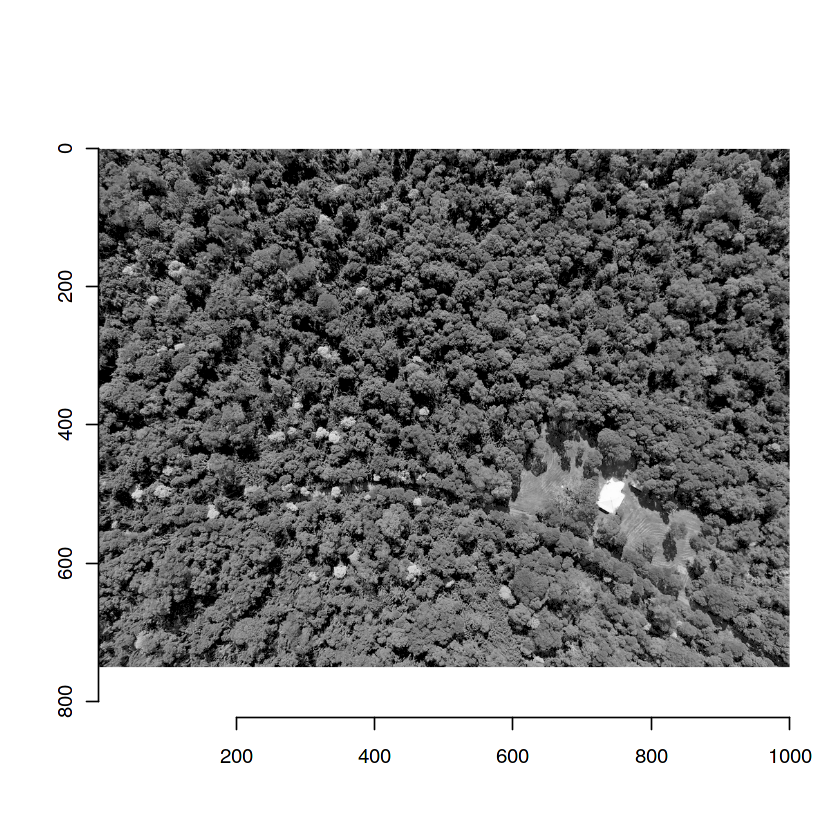

In [15]:
obj_oscuros <- (im_L[,]>param$mu[1])*im_L
plot(as.cimg(obj_oscuros))

# Relleno de sombras en grandes copas de árboles

La imagen en escala de grises (canal L) se invierte y se le suma el máximo valor de la escala de grises. Esto es comparable con una imagen negativa. Se computan dos imágenes baseline mediante un filtro RollingBall con un radio de tres píxeles. Las imágenes obtenidas se vuelven a invertir, y los valores máximos de la escala de grises se usaron para obtener la imagen final suavizada.

In [16]:
#inversión de imagen y adición de máximo de escala de grises
im_L_inv <- im_L*(-1)+max(im_L)
#baselines calculados
bline1 <- baseline(im_L,wm=3, ws=3, method='rollingBall')
bline2 <- baseline(im_L_inv,wm=3, ws=3, method='rollingBall')
#imagen suavizada
im_smooth <- pmax((bline1@baseline)*(-1),(bline2@baseline)*(-1))

Se prueba obteniendo un baseline usando como parámetro un valor de la mitad del tamaño máximo del objeto, y se añade a dicho baseline el valor máximo de la imagen en escala de grises

In [17]:
bline <- baseline(im_L,wm=3, ws=3, method='rollingBall')
im_smooth <- (bline1@baseline)*(-1)+max(max(im_L))

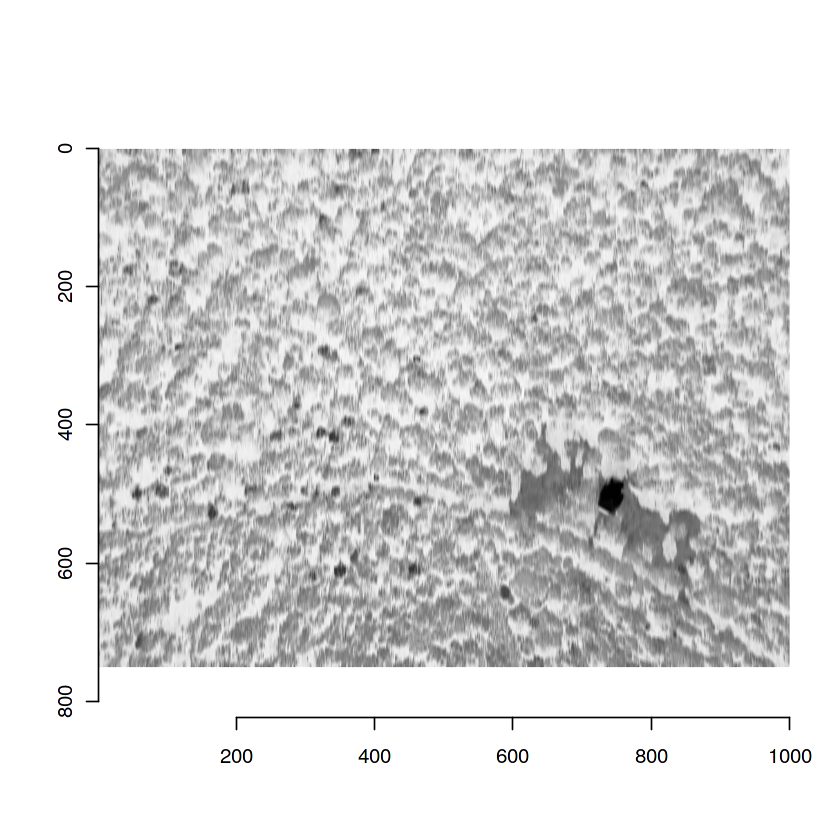

In [18]:
plot(as.cimg(im_smooth))

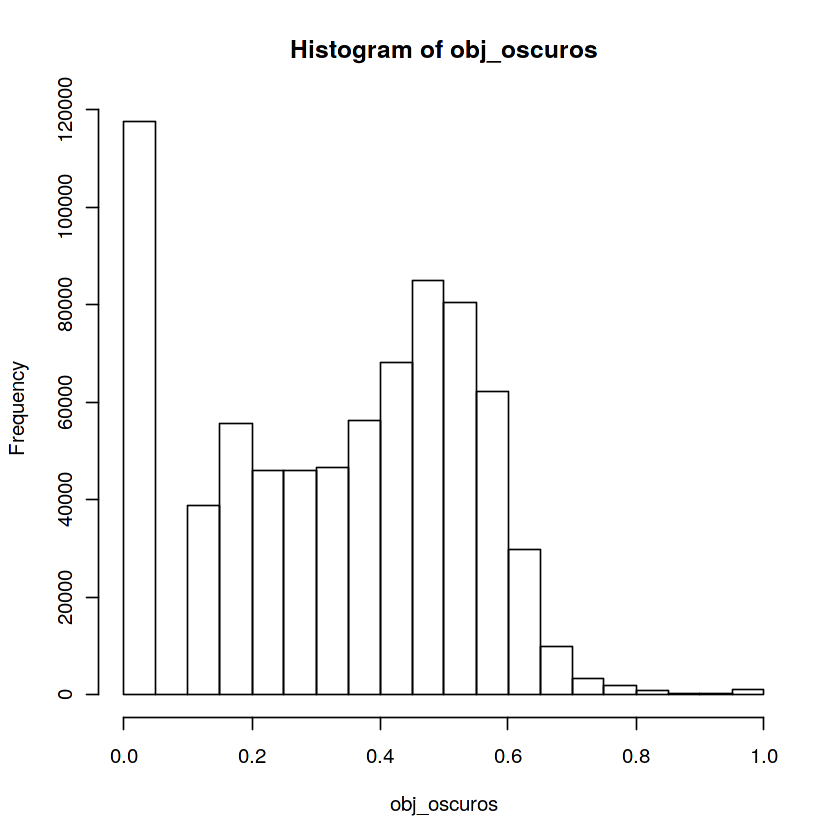

In [19]:
hist(obj_oscuros)

# Conclusiones